<a href="https://colab.research.google.com/github/fourmodern/toc_tutorial_colab/blob/main/teachopencadd/t045_diffdock.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DiffDock
Dock a PDB files and a SMILES with [DiffDock](https://github.com/gcorso/DiffDock).

Select Runtime / Run all to run an example PDB file and SMILES.

v2 improvements:
- works on proteins >1000 aas (with flag added to extract.py)
- works on standard GPU (by reducing batch size from 10 to 6)
- works with AlphaFold ids (AF-...) as well as PDB ids
- works with comma-delimited PDB_ids and/or SMILES
- runs smina to generate affinities (as DiffDock posed, or with smina minimization)
- shows results in a py3DMol view

v3:
- fix py3dmol incompatibility
- downgrade pytorch since the colab version takes forever to install pytorch_geometric (no binary so it has to compile)

v4:
- replace smina with the more accurate gnina
- remove the annoying run twice thing now there is a binary

v5:
- add ProLIF fingerprint

v6:
- bugfixes due to ProLIF version changes. prolif is now locked at 2.0.1

colab by [@btnaughton](https://twitter.com/btnaughton)

In [1]:
#@title PDB + SMILES input

PDB_id = '2ito' #@param {type:"string"}
SMILES_or_pubchem_id = 'COC1CC2NCNC(NC3CCC(F)C(Cl)C3)C2CC1OCCCN1CCOCC1' #@param {type:"string"}

#@markdown Download a tar file containing all results?
download_results = True #@param {type:"boolean"}

In [2]:
import os
import requests
import time
from random import random

def download_pdb_file(pdb_id: str) -> str:
    """Download pdb file as a string from rcsb.org"""
    PDB_DIR ="/tmp/pdb/"
    os.makedirs(PDB_DIR, exist_ok=True)

    # url or pdb_id
    if pdb_id.startswith('http'):
        url = pdb_id
        filename = url.split('/')[-1]
    elif pdb_id.endswith(".pdb"):
        return pdb_id
    else:
        if pdb_id.startswith("AF"):
            url = f"https://alphafold.ebi.ac.uk/files/{pdb_id}-model_v3.pdb"
        else:
            url = f"http://files.rcsb.org/view/{pdb_id}.pdb"
        filename = f'{pdb_id}.pdb'

    cache_path = os.path.join(PDB_DIR, filename)
    if os.path.exists(cache_path):
        return cache_path

    pdb_req = requests.get(url)
    pdb_req.raise_for_status()
    open(cache_path, 'w').write(pdb_req.text)
    return cache_path

def download_smiles_str(pubchem_id: str, retries:int = 2) -> str:
    """Given a pubchem id, get a smiles string"""
    while True:
        req = requests.get(f"https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/CID/{pubchem_id}/property/CanonicalSMILES/CSV")
        smiles_url_csv = req.text if req.status_code == 200 else None
        if smiles_url_csv is not None:
            break
        if retries == 0:
            return None
        time.sleep(1+random())
        retries -= 1

    return smiles_url_csv.splitlines()[1].split(',')[1].strip('"').strip("'") if smiles_url_csv is not None else None

In [3]:
if not PDB_id or not SMILES_or_pubchem_id:
    PDB_id = "6agt"
    SMILES_or_pubchem_id = "COc(cc1)ccc1C#N"
    print(f"No input supplied. Using example data: {PDB_id} and {SMILES_or_pubchem_id}")

# to run many PDB+smiles at once, fill in a list of PDB_files and smiles here...
pdb_files = [download_pdb_file(_PDB_id) for _PDB_id in PDB_id.split(",")]
smiless = [download_smiles_str(_SMILES_or_pubchem_id) if str(_SMILES_or_pubchem_id).isnumeric() else _SMILES_or_pubchem_id
           for _SMILES_or_pubchem_id in SMILES_or_pubchem_id.split(',') ]

with open("/tmp/input_protein_ligand.csv", 'w') as out:
    out.write("protein_path,ligand\n")
    for pdb_file in pdb_files:
        for smiles in smiless:
            out.write(f"{pdb_file},{smiles}\n")

In [4]:
# clear out old results if running multiple times -- hopefully they have been downloaded already
!rm -rf /content/DiffDock/results

## Install prerequisites

In [5]:
!pip install ipython-autotime --quiet
%load_ext autotime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 78.7 MB/s eta 0:00:00
time: 312 µs (started: 2024-12-14 02:06:29 +00:00)


In [6]:
if not os.path.exists("/content/DiffDock"):
    %cd /content
    !git clone https://github.com/gcorso/DiffDock.git
    %cd /content/DiffDock
    !git checkout a6c5275 # remove/update for more up to date code

/content
Cloning into 'DiffDock'...
remote: Enumerating objects: 517, done.
remote: Counting objects: 100% (511/511), done.
remote: Compressing objects: 100% (316/316), done.
remote: Total 517 (delta 244), reused 402 (delta 193), pack-reused 6 (from 1)
Receiving objects: 100% (517/517), 233.08 MiB | 16.68 MiB/s, done.
Resolving deltas: 100% (244/244), done.
/content/DiffDock
Note: switching to 'a6c5275'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by switching back to a branch.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -c with the switch command. Example:

  git switch -c <new-branch-name>

Or undo this operation with:

  git switch -

Turn off this advice by setting config variable advice.detachedHead to false

HEAD is now at a6c5275 remove debugging raise in the inference file
time: 2

In [7]:
try:
    import biopandas
except:
    !pip install pyg==0.7.1 --quiet
    !pip install pyyaml==6.0 --quiet
    !pip install scipy==1.7.3 --quiet
    !pip install networkx==2.6.3 --quiet
    !pip install biopython==1.79 --quiet
    !pip install rdkit-pypi==2022.03.5 --quiet
    !pip install e3nn==0.5.0 --quiet
    !pip install spyrmsd==0.5.2 --quiet
    !pip install pandas==1.5.3 --quiet
    !pip install biopandas==0.4.1 --quiet
    # not diffdock-specific:
    !pip install prolif==2.0.1 --quiet # no real version??
    !pip install py3dmol==2.0.3 --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.0/65.0 kB 5.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 682.2/682.2 kB 35.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 54.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.8/16.8 MB 97.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albucore 0.0.19 requires numpy>=1.24.4, but you have numpy 1.22.4 which is incompatible.
albumentations 1.4.20 requires numpy>=1.24.4, but you have numpy 1.22.4 which is incompatible.
albumentations 1.4.20 requires scipy>=1.10.0, but you have scipy 1.7.3 which is incompatible.
arviz 0.20.0 requires numpy>=1.23.0, but you have numpy 1.22.4 which

In [8]:
import torch
print(torch.__version__)

try:
    import torch_geometric
except ModuleNotFoundError:
    !pip uninstall torch-scatter torch-sparse torch-geometric torch-cluster  --y
    !pip install torch-scatter -f https://data.pyg.org/whl/torch-{torch.__version__}.html --quiet
    !pip install torch-sparse -f https://data.pyg.org/whl/torch-{torch.__version__}.html --quiet
    !pip install torch-cluster -f https://data.pyg.org/whl/torch-{torch.__version__}.html --quiet
    !pip install git+https://github.com/pyg-team/pytorch_geometric.git  --quiet # @ 15573f4674b2a37b1b9adc967df69ef6eee573ea

2.5.1+cu121
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 63.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 58.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 46.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
time: 23.3 s (started: 2024-12-14 02:08:00 +00:00)


## Install ESM and prepare PDB file for ESM

In [9]:
if not os.path.exists("/content/DiffDock/esm"):
    %cd /content/DiffDock
    !git clone https://github.com/facebookresearch/esm
    %cd /content/DiffDock/esm
    !git checkout ca8a710 # remove/update for more up to date code
    !sudo pip install -e .
    %cd /content/DiffDock

/content/DiffDock
Cloning into 'esm'...
remote: Enumerating objects: 1511, done.
remote: Counting objects: 100% (725/725), done.
remote: Compressing objects: 100% (194/194), done.
remote: Total 1511 (delta 567), reused 531 (delta 531), pack-reused 786 (from 1)
Receiving objects: 100% (1511/1511), 12.87 MiB | 17.29 MiB/s, done.
Resolving deltas: 100% (952/952), done.
/content/DiffDock/esm
Note: switching to 'ca8a710'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by switching back to a branch.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -c with the switch command. Example:

  git switch -c <new-branch-name>

Or undo this operation with:

  git switch -

Turn off this advice by setting config variable advice.detachedHead to false

HEAD is now at ca8a710 Update version.py (#310)
Obtaining file

In [10]:
%cd /content/DiffDock
!python datasets/esm_embedding_preparation.py --protein_ligand_csv /tmp/input_protein_ligand.csv --out_file data/prepared_for_esm.fasta

/content/DiffDock
100% 1/1 [00:00<00:00, 24.44it/s]
time: 707 ms (started: 2024-12-14 02:12:17 +00:00)


In [11]:
%cd /content/DiffDock
%env HOME=esm/model_weights
%env PYTHONPATH=$PYTHONPATH:/content/DiffDock/esm
!python /content/DiffDock/esm/scripts/extract.py esm2_t33_650M_UR50D data/prepared_for_esm.fasta data/esm2_output --repr_layers 33 --include per_tok --truncation_seq_length 30000

/content/DiffDock
env: HOME=esm/model_weights
env: PYTHONPATH=$PYTHONPATH:/content/DiffDock/esm
Downloading: "https://dl.fbaipublicfiles.com/fair-esm/models/esm2_t33_650M_UR50D.pt" to esm/model_weights/.cache/torch/hub/checkpoints/esm2_t33_650M_UR50D.pt
Downloading: "https://dl.fbaipublicfiles.com/fair-esm/regression/esm2_t33_650M_UR50D-contact-regression.pt" to esm/model_weights/.cache/torch/hub/checkpoints/esm2_t33_650M_UR50D-contact-regression.pt
Transferred model to GPU
Read data/prepared_for_esm.fasta with 1 sequences
Processing 1 of 1 batches (1 sequences)
time: 27.9 s (started: 2024-12-14 02:12:25 +00:00)


## Run DiffDock

In [12]:
%cd /content/DiffDock
!python -m inference --protein_ligand_csv /tmp/input_protein_ligand.csv --out_dir results/user_predictions_small --inference_steps 20 --samples_per_complex 40 --batch_size 6

/content/DiffDock
100% 201/201 [01:01<00:00,  3.29it/s]
100% 201/201 [01:22<00:00,  2.44it/s]
/content/DiffDock/utils/torus.py:38: RuntimeWarning: invalid value encountered in divide
  score_ = grad(x, sigma[:, None], N=100) / p_
Reading molecules and generating local structures with RDKit
100% 1/1 [00:00<00:00,  6.89it/s]
Reading language model embeddings.
/content/DiffDock/datasets/pdbbind.py:221: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly 

# Post-process and download results

In [13]:
%cd /content/DiffDock
!wget https://sourceforge.net/projects/smina/files/smina.static/download -O smina && chmod +x smina
!wget https://github.com/gnina/gnina/releases/download/v1.0.3/gnina -O gnina && chmod +x gnina

/content/DiffDock
--2024-12-14 02:23:47--  https://sourceforge.net/projects/smina/files/smina.static/download
Resolving sourceforge.net (sourceforge.net)... 104.18.13.149, 104.18.12.149, 2606:4700::6812:d95, ...
Connecting to sourceforge.net (sourceforge.net)|104.18.13.149|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://downloads.sourceforge.net/project/smina/smina.static?ts=gAAAAABnXOwzVs0qqf2c2teHeI-Q5kRZEmDh1eBXwQIfwepEv7PjQ_Mu0jERLZwF-x8TfDFVb4pjytzoj8Vu84K2rQfd9DEm9g%3D%3D&use_mirror=onboardcloud&r= [following]
--2024-12-14 02:23:48--  https://downloads.sourceforge.net/project/smina/smina.static?ts=gAAAAABnXOwzVs0qqf2c2teHeI-Q5kRZEmDh1eBXwQIfwepEv7PjQ_Mu0jERLZwF-x8TfDFVb4pjytzoj8Vu84K2rQfd9DEm9g%3D%3D&use_mirror=onboardcloud&r=
Resolving downloads.sourceforge.net (downloads.sourceforge.net)... 104.18.12.149, 104.18.13.149, 2606:4700::6812:d95, ...
Connecting to downloads.sourceforge.net (downloads.sourceforge.net)|104.18.12.149|:443... connec

## Run gnina to estimate affinity

In [14]:
import re
import pandas as pd
from glob import glob
from shlex import quote
from datetime import datetime
from tqdm.auto import tqdm
from google.colab import files

%cd /content/DiffDock/results/user_predictions_small
results_dirs = glob("./index*")

rows = []
for results_dir in tqdm(results_dirs, desc="runs"):
    results_pdb_file = "/tmp/pdb/" + re.findall("tmp-pdb-(.+\.pdb)", results_dir)[0]
    results_smiles = re.findall("pdb_+(.+)", results_dir)[0]
    results_sdfs = [os.path.join(results_dir, f) for f in os.listdir(results_dir) if "confidence" in f and f.endswith(".sdf")]

    results_pdb_file_no_hetatms = f"{results_pdb_file}_nohet.pdb"
    !grep -v "^HETATM" {results_pdb_file} > {results_pdb_file_no_hetatms}
    !cp {results_pdb_file} .

    for results_sdf in tqdm(results_sdfs, leave=False, desc="files"):
        confidence = re.findall("confidence([\-\.\d]+)\.sdf", results_sdf)[0]

        scored_stdout = !/content/DiffDock/gnina --score_only -r "{results_pdb_file_no_hetatms}" -l "{results_sdf}"
        scored_affinity = re.findall("Affinity:\s*([\-\.\d+]+)", '\n'.join(scored_stdout))[0]
        minimized_stdout = !/content/DiffDock/gnina --local_only --minimize -r "{results_pdb_file_no_hetatms}" -l "{results_sdf}" --autobox_ligand "{results_sdf}" --autobox_add 2
        minimized_affinity = re.findall("Affinity:\s*([\-\.\d+]+)", '\n'.join(minimized_stdout))[0]

        rows.append((results_pdb_file.split('/')[-1], results_smiles, float(confidence), float(scored_affinity), float(minimized_affinity), results_sdf))

df_results = pd.DataFrame(rows, columns=["pdb_file", "smiles", "diffdock_confidence", "gnina_scored_affinity", "gnina_minimized_affinity", "sdf_file"])
df_results_tsv = "df_diffdock_results.tsv"
df_results.to_csv(df_results_tsv, sep='\t', index=None)

/content/DiffDock/results/user_predictions_small


runs:   0%|          | 0/1 [00:00<?, ?it/s]

files:   0%|          | 0/40 [00:00<?, ?it/s]

time: 1min (started: 2024-12-14 02:24:04 +00:00)


### Top hit by DiffDock confidence for any PDB/smiles combination

In [15]:
top_hit = df_results.sort_values("diffdock_confidence", ascending=False).iloc[0]
df_results.sort_values("diffdock_confidence", ascending=False).head(3)

,pdb_file,smiles,diffdock_confidence,gnina_scored_affinity,gnina_minimized_affinity,sdf_file
30,2ito.pdb,COC1CC2NCNC(NC3CCC(F)C(Cl)C3)C2CC1OCCCN1CCOCC1,-0.62,-5.98055,-7.64603,./index0_-tmp-pdb-2ito.pdb____COC1CC2NCNC(NC3C...
14,2ito.pdb,COC1CC2NCNC(NC3CCC(F)C(Cl)C3)C2CC1OCCCN1CCOCC1,-0.84,-0.39806,-7.48349,./index0_-tmp-pdb-2ito.pdb____COC1CC2NCNC(NC3C...
4,2ito.pdb,COC1CC2NCNC(NC3CCC(F)C(Cl)C3)C2CC1OCCCN1CCOCC1,-0.85,-4.35394,-7.37890,./index0_-tmp-pdb-2ito.pdb____COC1CC2NCNC(NC3C...


time: 22.7 ms (started: 2024-12-14 02:25:04 +00:00)


## Show prolif fingerprint

In [16]:
import prolif as plf
from prolif.plotting.network import LigNetwork
from rdkit import Chem

# load protein
prot = Chem.MolFromPDBFile(top_hit.pdb_file, removeHs=False)
prot = plf.Molecule(prot)

# load ligands
lig_suppl = list(plf.sdf_supplier(top_hit.sdf_file))

# generate fingerprint
fp = plf.Fingerprint()
fp.run_from_iterable(lig_suppl, prot)

df_prolif = fp.to_dataframe()
display(df_prolif)

prolif_fingerprint_html = "prolif_fingerprint.html"
net = LigNetwork.from_fingerprint(fp, lig_suppl[0], kind="frame", frame=0, rotation=0)
net.save(prolif_fingerprint_html)
net.display()

/usr/local/lib/python3.10/dist-packages/MDAnalysis/topology/tables.py:52: DeprecationWarning: Deprecated in version 2.8.0
MDAnalysis.topology.tables has been moved to MDAnalysis.guesser.tables. This import point will be removed in MDAnalysis version 3.0.0
  warnings.warn(wmsg, category=DeprecationWarning)


  0%|          | 0/1 [00:00<?, ?it/s]

ligand            UNL1                                               \
protein       LEU718.A   LYS745.A   LEU792.A   MET793.A    LEU844.A   
interaction VdWContact VdWContact VdWContact VdWContact Hydrophobic   
Frame                                                                 
0                 True       True       True       True        True   

ligand                              
protein       IRE2020.A             
interaction Hydrophobic VdWContact  
Frame                               
0                  True       True

time: 936 ms (started: 2024-12-14 02:25:05 +00:00)


## Create dataframe, tar file and download

In [17]:
out_pdbs = ' '.join(set(df_results.pdb_file.apply(quote)))
out_sdfs = ' '.join(df_results.sdf_file.apply(quote))

if download_results:
    tarname = f"diffdock_{datetime.now().isoformat()[2:10].replace('-','')}"
    _ = !tar cvf {tarname}.tar --transform 's,^,{tarname}/,' --transform 's,\./,,' {out_pdbs} {out_sdfs} {df_results_tsv} {prolif_fingerprint_html}

    files.download(f"{tarname}.tar")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

time: 114 ms (started: 2024-12-14 02:25:05 +00:00)


## Compare gnina affinities with DiffDock confidences

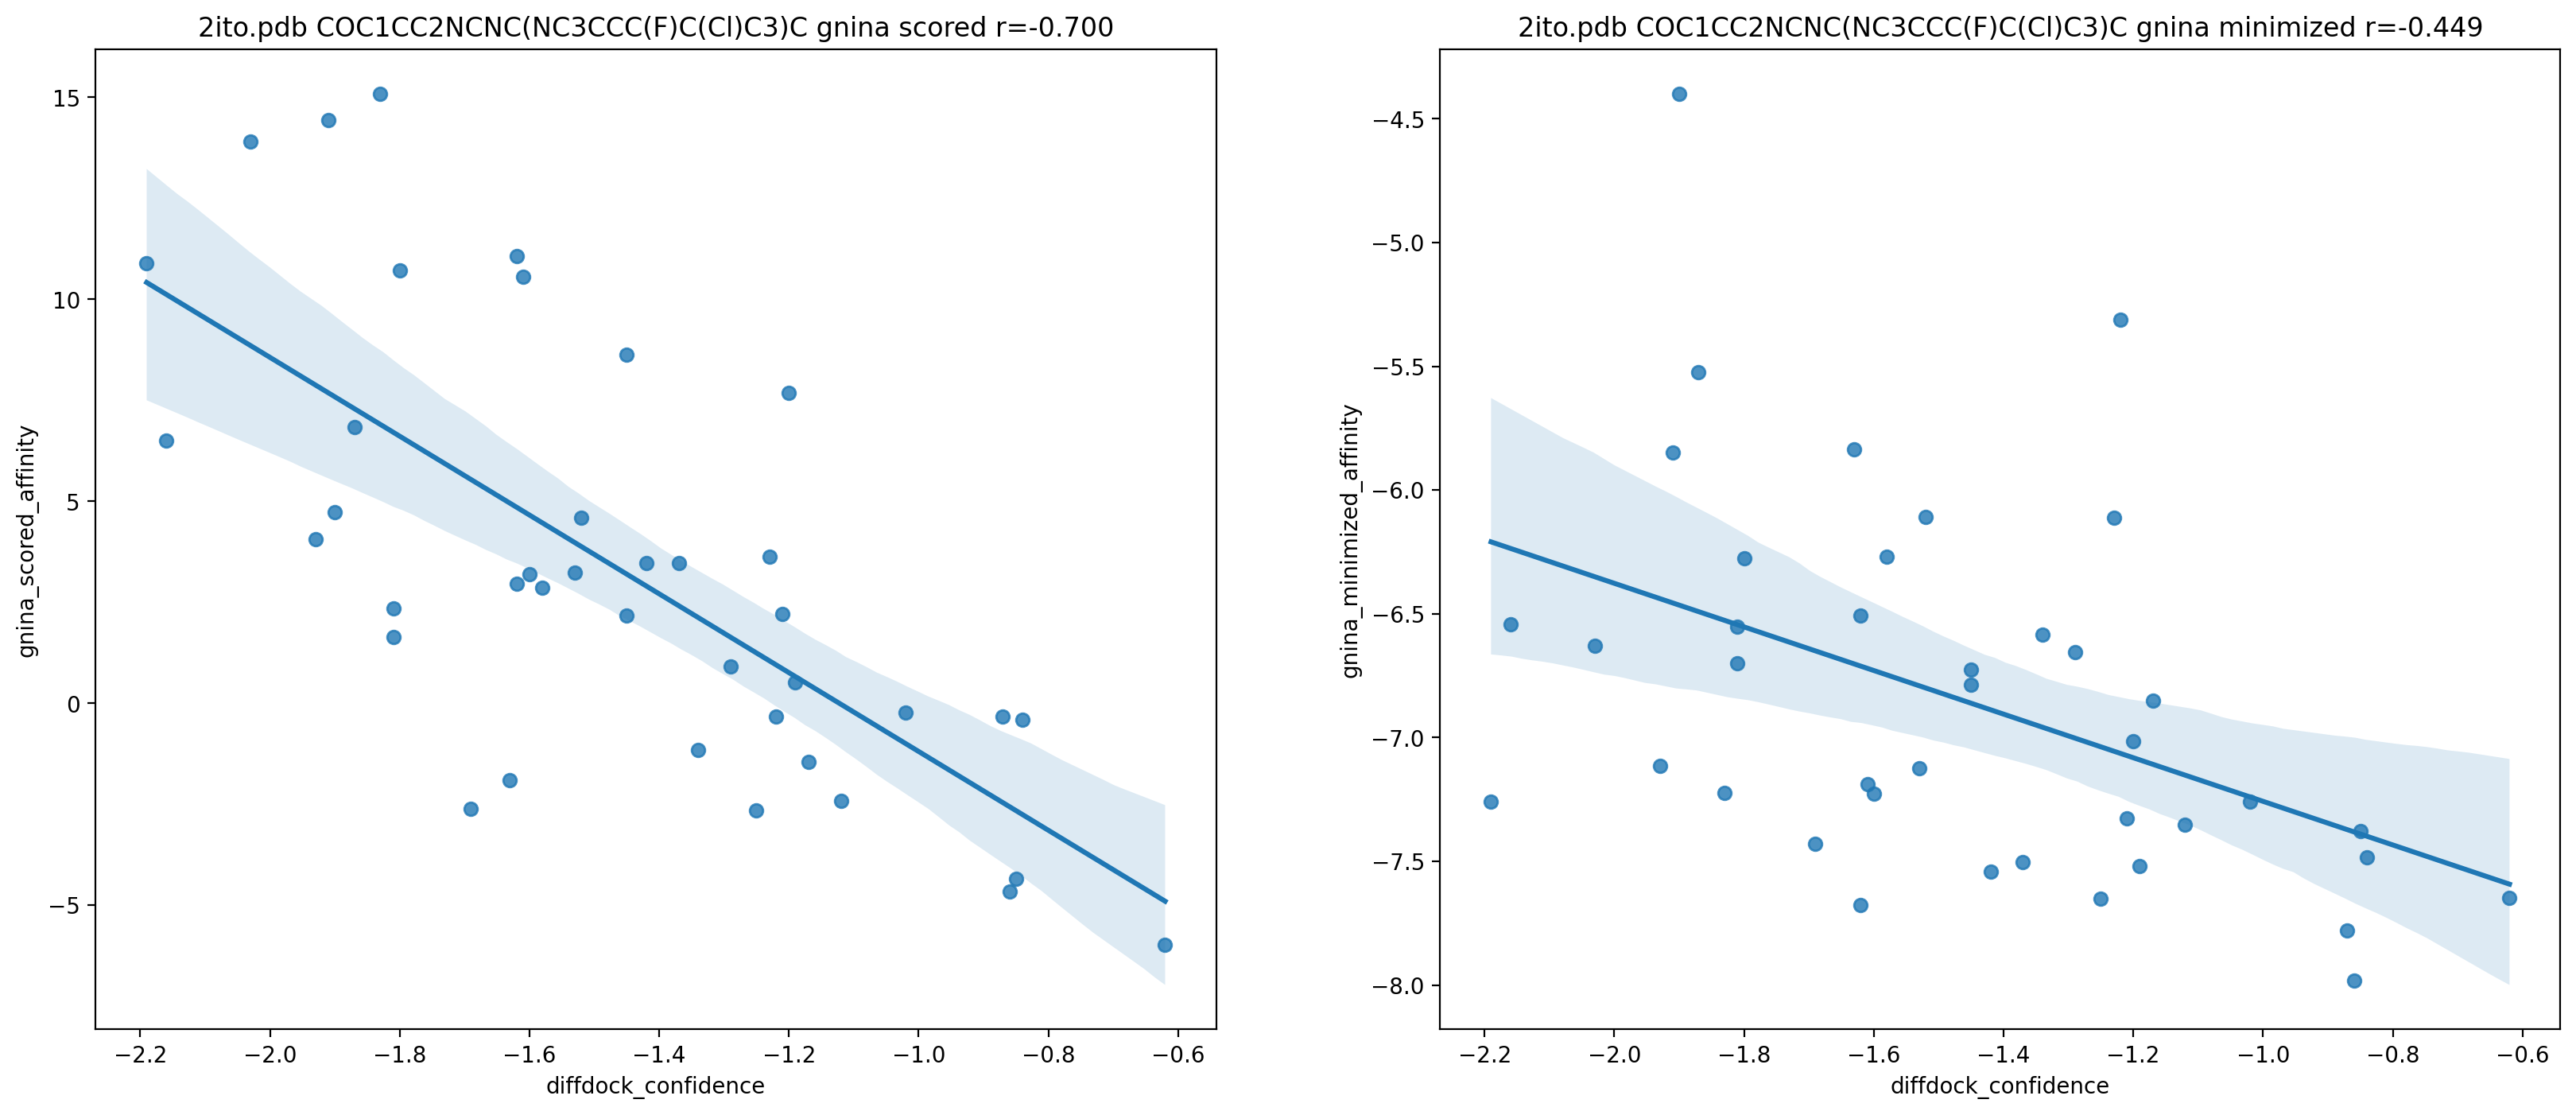

time: 1.64 s (started: 2024-12-14 02:25:06 +00:00)


In [18]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import linregress
%config InlineBackend.figure_format='retina'

for (pdb_file, smiles), df_group in df_results.groupby(["pdb_file", "smiles"]):
    f, ax = plt.subplots(1, 2, figsize=(20,8))
    sns.regplot(data=df_group, x="diffdock_confidence", y="gnina_scored_affinity", ax=ax[0]);
    sns.regplot(data=df_group, x="diffdock_confidence", y="gnina_minimized_affinity", ax=ax[1]);

    slope, intercept, r_value_scored, p_value, std_err = linregress(df_group["diffdock_confidence"], df_group["gnina_scored_affinity"])
    slope, intercept, r_value_minimized, p_value, std_err = linregress(df_group["diffdock_confidence"], df_group["gnina_minimized_affinity"])
    ax[0].set_title(f"{pdb_file} {smiles[:30]} gnina scored r={r_value_scored:.3f}");
    ax[1].set_title(f"{pdb_file} {smiles[:30]} gnina minimized r={r_value_minimized:.3f}");

# Visualize top hit (highest confidence) in 3D

In [19]:
from IPython.display import HTML
import py3Dmol

resid_hover = """
function(atom,viewer) {
    if(!atom.label) {
        atom.label = viewer.addLabel(atom.chain+" "+atom.resn+" "+atom.resi,
            {position: atom, backgroundColor: 'mintcream', fontColor:'black', fontSize:12});
    }
}"""
unhover_func = """
function(atom,viewer) {
    if(atom.label) {
        viewer.removeLabel(atom.label);
        delete atom.label;
    }
}"""

view = py3Dmol.view(width=800, height=800)
view.setCameraParameters({'fov': 35, 'z': 100});


# add sdf
view.addModel(open(top_hit.sdf_file).read(), "sdf")
view.setStyle({"model": 0}, {'stick':{"color":"#ff0000"}})
view.setViewStyle({"model": 0}, {'style':'outline','color':'black','width':0.1})
view.zoomTo();

# add pdb
view.addModel(open(top_hit.pdb_file).read(), "pdb");
view.setStyle({"model": 1}, {"cartoon":{"color":"spectrum"}})
view.setStyle({"model": 1, "hetflag":True}, {'stick':{"color":"spectrum"}})

model = view.getModel()
model.setHoverable({}, True, resid_hover, unhover_func)

view

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

time: 24.6 ms (started: 2024-12-14 02:25:07 +00:00)
